In [1]:
# Detections
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
# Homography
from homography import HomographyTransformer
from pitch_config import SoccerFieldConfiguration
PITCH_CONFIG = SoccerFieldConfiguration()

In [2]:
ball_detector = YOLO(r"C:\Users\leoac\vtg-automation\ball_position_estimation\models\ball_detector_yolov10m_ultralytics=8.2.71.pt")
pitch_detector = YOLO(r"C:\Users\leoac\vtg-automation\pitch_detection\YOLOv8-pose\runs\train2\weights\pitch_detector_YOLOv8-pose_ultralyitcs=8.2.71_training2.pt")

In [3]:
if not ('ball_detector' in globals()):
    ball_detector = YOLO(r"C:\Users\leoac\vtg-automation\ball_position_estimation\models\ball_detector_yolov10m_ultralytics=8.2.71.pt")
else:
    print("Ball detector already loaded")

Ball detector already loaded


In [4]:
# input_image_path = r"C:\Users\leoac\vtg-automation\data\frames\99997_A_italy_frame_80_Receive.png"
input_image_path = r"C:\Users\leoac\vtg-automation\data\YOLOv8_Pytorch_TXT_not_empty\test\images\790204684469_D_clubMilano_frame_259_Aerial.png"
# input_image_path = r"C:\background_images\img-eEYHk4Mp8uHFp0cMqhi2WhyB.png"
# input_image_path = r"C:\Users\leoac\vtg-automation\data\frames_batches\batch_22\650441685106_D_clubMilano_frame_1069_Def-action.png"

In [5]:
ball = ball_detector.predict(input_image_path)
ball_detections = sv.Detections.from_ultralytics(ball[0])
if len(ball) == 0:
    print("No ball detected")
else:
    ball_pixels_xy = np.array([(ball_detections.xyxy[0][0] + ball_detections.xyxy[0][2]) / 2, (ball_detections.xyxy[0][1] + ball_detections.xyxy[0][3]) / 2]) # An array containing the xy coordinates calculated as the centre of the bounding box


image 1/1 C:\Users\leoac\vtg-automation\data\YOLOv8_Pytorch_TXT_not_empty\test\images\790204684469_D_clubMilano_frame_259_Aerial.png: 384x640 1 soccer_ball, 461.8ms
Speed: 1.9ms preprocess, 461.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [6]:
pitch = pitch_detector.predict(input_image_path)
pitch_detections = sv.Detections.from_ultralytics(pitch[0])
if len(pitch_detections) == 0:
    print("No ball detected")
pitch_keypoints = pitch[0].keypoints.xy.reshape(len(pitch_detections), 2) # Reshape to match the pitch_config vertices shape


image 1/1 C:\Users\leoac\vtg-automation\data\YOLOv8_Pytorch_TXT_not_empty\test\images\790204684469_D_clubMilano_frame_259_Aerial.png: 384x640 1 O2, 2 O3s, 1 O4, 1 O5, 1 O7, 1 O8, 2376.8ms
Speed: 6.0ms preprocess, 2376.8ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


In [7]:
# # TRIAL: Euristics for deleting points misplaced
# # Min O and Max D
# D_indices = np.where(np.char.find(pitch_detections.data['class_name'], 'D') >= 0)[0]
# O_indices = np.where(np.char.find(pitch_detections.data['class_name'], 'O') >= 0)[0]
# M_indices = np.where(np.char.find(pitch_detections.data['class_name'], 'M') >= 0)[0]

# D_xx = pitch_detections[D_indices].xyxy[:,(0,2)]
# D_x_max = np.max(D_xx)
# O_xx = pitch_detections[O_indices].xyxy[:,(0,2)]
# O_x_min = np.min(O_xx)

# for detection in pitch_detections:
#     data = detection[5]
#     xyxy = detection[0]
#     if 'O' in data['class_name'] and xyxy[2] < :
#         print(detection)

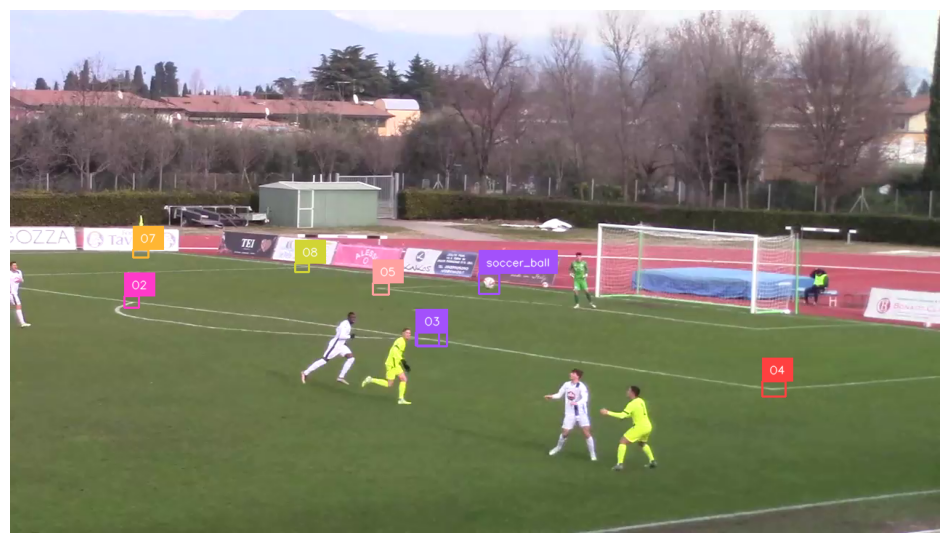

In [8]:
image = cv2.imread(input_image_path)
detections = sv.Detections.merge([ball_detections, pitch_detections])

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [9]:
pitch[0].keypoints.cls = pitch[0].boxes.cls
keypoints_ids = pitch[0].keypoints.cls.tolist()
keypoints_xy = [PITCH_CONFIG.vertices[id]['xy'] for id in keypoints_ids]

In [10]:
transformer = HomographyTransformer()

In [12]:
ball_x, ball_y = transformer.transform_points(points=ball_pixels_xy,
                                                detected_keypoints=np.array(pitch_keypoints).astype(np.float32),
                                                pitch_vertices=np.array(keypoints_xy).astype(np.float32))[0]

In [13]:
ball_x / 100, ball_y / 100

(103.797333984375, 25.2692431640625)

# Visualization

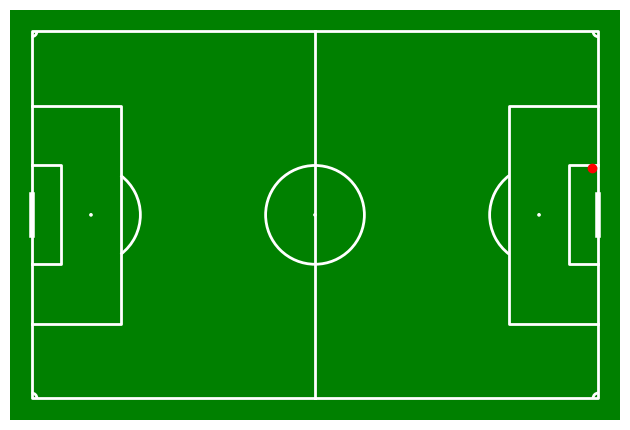

In [14]:
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt

# Create a pitch object
# You can customize the pitch type, line color, and line zorder among other parameters
pitch = Pitch(
    pitch_type='custom',
    pitch_length=105,
    pitch_width=68,
    line_color='white',
    line_zorder=0,
    pitch_color='green',
    corner_arcs=True
)

# Plot the pitch
fig, ax = pitch.draw()
ax.invert_yaxis()
ax.plot(ball_x / 100, ball_y / 100, 'ro', zorder=1)

# Show the plot
plt.show()

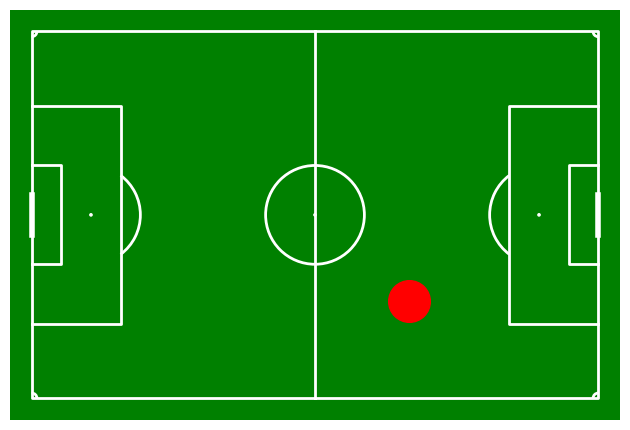

In [5]:
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt

# Create a pitch object
# You can customize the pitch type, line color, and line zorder among other parameters
pitch = Pitch(
    pitch_type='custom',
    pitch_length=105,
    pitch_width=68,
    line_color='white',
    line_zorder=0,
    pitch_color='green',
    corner_arcs=True
)

# Plot the pitch
fig, ax = pitch.draw()
ax.invert_yaxis()
ax.plot(7000 / 100, 5000 / 100, 'ro', zorder=1, markersize=30)

# Show the plot
plt.show()

# Try the pipeline

In [1]:
from pipeline import BallPositionPipeline

In [2]:
pipeline = BallPositionPipeline(
    ball_detector_model_path=r"C:\Users\leoac\vtg-automation\ball_position_estimation\models\ball_detector_yolov10m_ultralytics=8.2.71.pt",
    pitch_detector_model_path=r"C:\Users\leoac\vtg-automation\pitch_detection\YOLOv8-pose\runs\train2\weights\pitch_detector_YOLOv8-pose_ultralyitcs=8.2.71_training2.pt"
)

In [3]:
# image_path = r"C:\Users\leoac\vtg-automation\data\YOLOv8_Pytorch_TXT_not_empty\test\images\99997_A_italy_frame_1625_Receive.png"
# image_path = r"C:\background_images\img-eEYHk4Mp8uHFp0cMqhi2WhyB.png"
image_path = r"C:\Users\leoac\Downloads\USATSI_19520555_168393969_lowres-scaled-e1697215176168.webp"
ball_x, ball_y = pipeline.predict(input_image_path=image_path)


image 1/1 C:\Users\leoac\Downloads\USATSI_19520555_168393969_lowres-scaled-e1697215176168.webp: 448x640 2 soccer_balls, 596.7ms
Speed: 0.0ms preprocess, 596.7ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\leoac\Downloads\USATSI_19520555_168393969_lowres-scaled-e1697215176168.webp: 448x640 (no detections), 1235.2ms
Speed: 0.0ms preprocess, 1235.2ms inference, 11.3ms postprocess per image at shape (1, 3, 448, 640)
Not enough keypoints detected: detected 0, needed at least 4.
Ball position could not be estimated.


In [5]:
if (ball_x, ball_y) == (-1, -1):
    print("No ball detected")

No ball detected


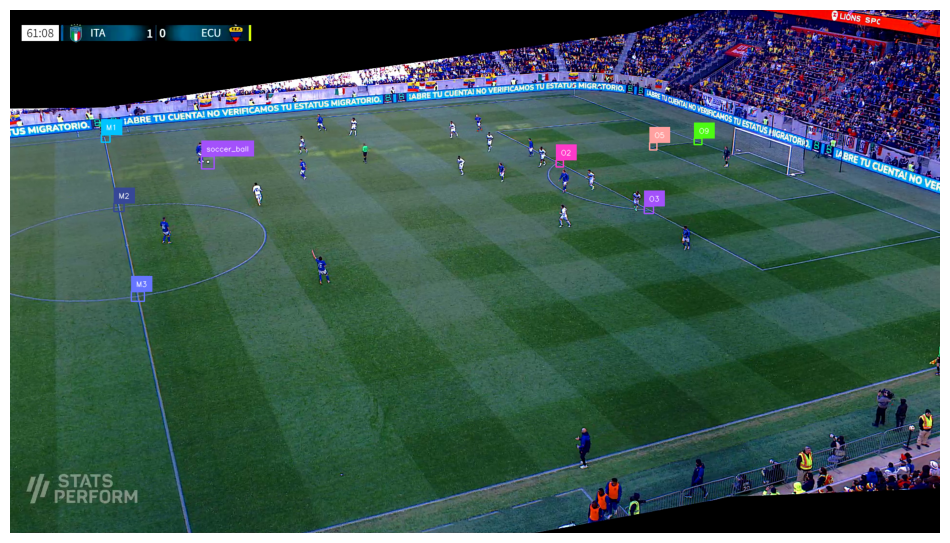

In [ ]:
pipeline.plot_annotated_image()

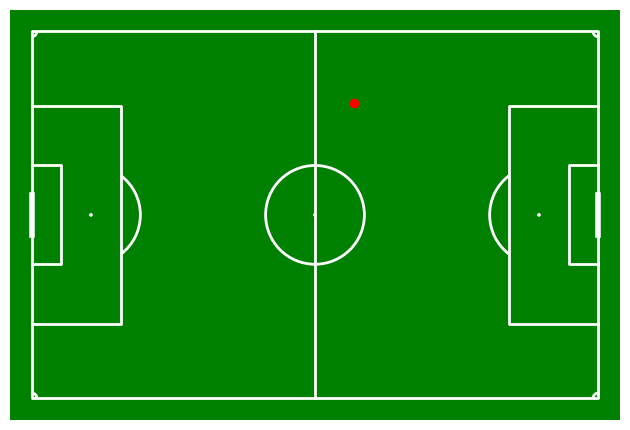

In [12]:
pipeline.plot_radar(ball_x=ball_x, ball_y=ball_y)